In [4]:
%pip install --quiet -U langgraph duckduckgo-search langchain_core langchain_community langchain_ollama sounddevice scipy numpy==1.26.4 openai-whisper librosa phonemizer torch transformers scipy munch


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")

import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "voice assistance"

LANGCHAIN_API_KEY:  ········


## Whisper (ASR)

In [43]:
import ssl
import torch
import whisper

ssl._create_default_https_context = ssl._create_unverified_context

device = "cuda:0" if torch.cuda.is_available() else "cpu"
whisper_model = whisper.load_model("small", device=device)

100%|███████████████████████████████████████| 461M/461M [00:23<00:00, 20.4MiB/s]


## Kokoro (TTS)

In [8]:
!git clone https://huggingface.co/hexgrad/Kokoro-82M

Cloning into 'Kokoro-82M'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 140 (delta 63), reused 0 (delta 0), pack-reused 4 (from 1)
Receiving objects: 100% (140/140), 60.13 KiB | 10.02 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Filtering content: 100% (17/17), 820.18 MiB | 33.83 MiB/s, done.


In [9]:
%cd Kokoro-82M

/Users/crixus/Documents/langgraph_examples/voice_assistance/Kokoro-82M


In [64]:
from models import build_model
import torch
from kokoro import generate

device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL = build_model('kokoro-v0_19.pth', device)
VOICE_NAME = [
    'af', # Default voice is a 50-50 mix of Bella & Sarah
    'af_bella', 'af_sarah', 'am_adam', 'am_michael',
    'bf_emma', 'bf_isabella', 'bm_george', 'bm_lewis',
    'af_nicole', 'af_sky',
][9]
VOICEPACK = torch.load(f'voices/{VOICE_NAME}.pt', weights_only=True).to(device)

## Tools

In [65]:
from langchain_community.tools import DuckDuckGoSearchResults

search = DuckDuckGoSearchResults(k=5)

In [66]:
tools = [search]

## LLM

In [67]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
        base_url="http://localhost:11434",
        model="llama3.2",
        temperature=0,
        streaming=True
    )

In [68]:
llm_with_tools = llm.bind_tools(tools)

## Prompt

In [69]:
prompt = (
    """
    You are an AI assistant focused on delivering accurate, professional, and helpful responses. Your goal is to provide high-quality information while maintaining a courteous tone. Follow these steps:
    
    1. **Knowledge and Search Protocol**:
       - **Internal Knowledge First**: Always use your knowledge base for straightforward questions that do not require up-to-date or specialized data. Only initiate a search if the query is complex, highly specialized, or requires current information.
       - **Search When Necessary**: If unsure or the topic is beyond your internal knowledge, or if verification of specific details is needed, search for current or detailed information.
    
    2. **Response Quality**:
       - Provide clear, well-structured answers with relevant context.
       - Be precise and accurate, citing sources when using searched data.
       - Maintain clarity and simplicity, adapting to the user’s expertise.
    
    3. **Communication Style**:
       - Use formal, respectful language.
       - Organize information logically.
       - Be transparent when using external data.
    
    4. **Error Handling**:
       - Acknowledge when unsure or conflicting information arises.
       - Suggest alternatives or offer to search more if needed.
    
    5. **Follow-up and Support**:
       - Provide additional insights, suggest related topics, and be open to clarifications.
    """
)

In [70]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", prompt),
    ("placeholder", "{message}")
])

## Graph

In [71]:
import threading

import io
import threading
import numpy as np
from scipy.io.wavfile import write

import librosa
import sounddevice as sd

from typing import List, Literal
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.graph import MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [72]:
def assistant(state: MessagesState):
    formated_promt = prompt.format(message=state["messages"])
    message = [{"role": "system", "content": formated_promt}] + state["messages"]
    return {"messages": [llm_with_tools.invoke(message)]}


In [73]:
def record_audio_until_stop(state: MessagesState):

    """Records audio from the microphone until Enter is pressed, then saves it to a .wav file."""
    
    audio_data = []  # List to store audio chunks
    recording = True  # Flag to control recording
    sample_rate = 16000 # (kHz) Adequate for human voice frequency

    def record_audio():
        """Continuously records audio until the recording flag is set to False."""
        nonlocal audio_data, recording
        with sd.InputStream(samplerate=sample_rate, channels=1, dtype='int16') as stream:
            print("Recording your instruction! ... Press Enter to stop recording.")
            while recording:
                audio_chunk, _ = stream.read(1024)  # Read audio data in chunks
                audio_data.append(audio_chunk)

    def stop_recording():
        """Waits for user input to stop the recording."""
        input()  # Wait for Enter key press
        nonlocal recording
        recording = False

    # Start recording in a separate thread
    recording_thread = threading.Thread(target=record_audio)
    recording_thread.start()

    # Start a thread to listen for the Enter key
    stop_thread = threading.Thread(target=stop_recording)
    stop_thread.start()

    # Wait for both threads to complete
    stop_thread.join()
    recording_thread.join()

    # Stack all audio chunks into a single NumPy array and write to file
    audio_data = np.concatenate(audio_data, axis=0)
    
    # Convert to WAV format in-memory
    audio_bytes = io.BytesIO()
    write(audio_bytes, sample_rate, audio_data)  # Use scipy's write function to save to BytesIO
    audio_bytes.seek(0)  # Go to the start of the BytesIO buffer
    audio_bytes.name = "audio.wav" # Set a filename for the in-memory file

    # Load audio data as NumPy array
    audio_np, sr = librosa.load(audio_bytes, sr=None, mono=True)

    # Preprocess and transcribe using Whisper
    audio = whisper.pad_or_trim(audio_np)
    mel = whisper.log_mel_spectrogram(audio).to(device)

    # Detect language
    _, probs = whisper_model.detect_language(mel)
    detected_language = max(probs, key=probs.get)

    # Transcribe
    # options = {"language": detected_language, "task": "transcribe"}
    options = {"language": "en", "task": "transcribe"}
    transcription = whisper_model.transcribe(audio, **options, fp16=False)
    

    # Print the transcription
    print("Here is the transcription:", transcription["text"])

    # Write to messages 
    return {"messages": [HumanMessage(content=transcription["text"])]}

In [74]:
def play_audio_from_text(state: MessagesState):
    """
    Generate and play audio from the given text in one method.
    """
    chunk_size = 200
    message = state['messages'][-1]
    
    # Step 1: Create smaller chunks with sentence-aware breaks
    def create_smaller_chunks(message, chunk_size):
        text = message.content.replace("*", "")
        text = text.replace('\n', ' ').strip()
        chunks = []
        start = 0
        
        while start < len(text):
            end = start + chunk_size
            
            if end < len(text):
                last_period = text.rfind('. ', start, end)
                last_question = text.rfind('? ', start, end)
                last_exclaim = text.rfind('! ', start, end)
                
                break_point = max(last_period, last_question, last_exclaim)
                
                if break_point != -1 and break_point > start:
                    end = break_point + 2
                else:
                    last_space = text.rfind(' ', start, end)
                    if last_space != -1 and last_space > start:
                        end = last_space + 1
                    else:
                        end = min(start + chunk_size, len(text))
            else:
                end = len(text)
            
            chunk = text[start:end].strip()
            chunks.append(chunk)
            start = end
        
        return chunks

    # Step 2: Process the text into chunks
    print("Starting text processing with smaller chunks...")
    chunks = create_smaller_chunks(message, chunk_size)
    # print(f"\nCreated {len(chunks)} chunks")

    # Step 3: Generate audio for each chunk
    audio_chunks = []
    for i, chunk in enumerate(chunks, 1):
        # print(f"\nProcessing chunk {i}/{len(chunks)}")
        # print(f"Chunk length: {len(chunk)}")
        # print(f"Chunk content: {chunk}")
        audio, out_ps = generate(MODEL, chunk, VOICEPACK, lang=VOICE_NAME[0])
        audio_chunks.append(audio)

    # Step 4: Concatenate and play the final audio
    final_audio = np.concatenate(audio_chunks)

    # Step 5: Play the audio using sounddevice
    samplerate = 24000  # Kokoro's default sample rate
    sd.play(final_audio, samplerate)
    sd.wait()  # Wait until the audio is finished playing


In [75]:
def route_assistant(state: MessagesState) -> Literal["tools", "audio_output"]:
    # Your logic to decide whether to use tools or go to audio output
    # For example:
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return "audio_output"

In [76]:
memory = MemorySaver()
builder = StateGraph(MessagesState)

builder.add_node("audio_input", record_audio_until_stop)
builder.add_node("assistant", assistant)
builder.add_node(ToolNode(tools))
builder.add_node("audio_output", play_audio_from_text)

builder.add_conditional_edges(
    "assistant",
    route_assistant,
    {
        "audio_output": "audio_output",
        "tools": "tools",
    }
)

builder.add_edge(START, "audio_input")
builder.add_edge("audio_input", "assistant")
builder.add_edge("tools", "assistant")
builder.add_edge("audio_output", END)


graph = builder.compile(checkpointer=memory)

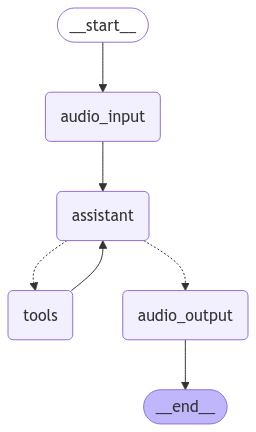

In [77]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Test

In [84]:
import uuid
thread_id = str(uuid.uuid4())

In [86]:
config = {"configurable": {"user_id": "Audio Assistant", "thread_id": thread_id}}

for chunk in graph.stream({"messages": HumanMessage(content="Follow the user's instructions:")}, stream_mode="values", config=config):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Follow the user's instructions:
Recording your instruction! ... Press Enter to stop recording.


Here is the transcription:  Create a poem about rabbits.
================================ Human Message =================================

 Create a poem about rabbits.
================================== Ai Message ==================================
Tool Calls:
  generate_poem (2cfaf529-46d1-49c1-a955-ca76341fd92a)
 Call ID: 2cfaf529-46d1-49c1-a955-ca76341fd92a
  Args:
    k: 5
    n: 10
    p: rabbits
================================= Tool Message =================================
Name: generate_poem

Error: generate_poem is not a valid tool, try one of [duckduckgo_results_json].
================================== Ai Message ==================================

Here's a poem about rabbits:

In sun-kissed meadows, they love to play,
Rabbits dancing, on a warm summer day.
Their fur so soft, their eyes so bright,
They hop and leap, with joyful delight.

With twitching noses, they sniff the air,
 Searching for carrots, without a care.
Their little paws, move quick as can be,
As they explor